# CAPM Beta Estimation and Regression Diagnostics

**Author:** Alexander Stephan   
**Date:** July 2, 2025

# Project Overview & Background Information

This project estimates the **Capital Asset Pricing Model (CAPM) Beta** for three well-known stocks, Apple (AAPL), Tesla (TSLA), and JPMorgan Chase (JPM), using the S&P 500 (^GSPC) as a market benchmark. **The goal is to assess each stock's sensitivity to wider market movements and compare risk profiles between sectors.** The estimations will use data starting from Q2 2024 and ending after Q1 2025.

## The Capital Asset Pricing Model (CAPM)
The Capital Asset Pricing Model is a financial model that describes the linear relationship between an asset's **expected return** and its **systematic risk**, represented by Beta ($\beta$). It is often expressed as:


$E(R_i) = R_f + \beta_i (E(R_m) - R_f)$  
Where:  
- $E(R_i) =$ Expected return of the investment  
- $R_f =$ Risk-free rate (ignored in this simplified analysis, as its impact is negligible compared to short-term market volatility)  
- $E(R_m) =$ Expected return of the market  
- $\beta_i =$ Beta of the investment

In practical terms:  
- Assets **above** the CAPM line have greater-than-expected returns and are said to have a positive alpha
- Assets **below** the line produce lower returns than expected and are said to have a negative alpha


## Understanding Beta
Beta ($\beta$) measures **how sensitive a stock's returns are to changes in the wider market**, predicting the stock's responsiveness to market fluctuations. By definition, the market's beta is 1.

- **$\beta$ > 1** → Stock is more volatile than the market
- **$\beta$ = 1** → Stock moves similarly to the market 
- **$\beta$ < 1** → Stock is less volatile than the market


For example:
- A stock with **$\beta$ = 2** is expected to move twice as much as the market.
- A stock with **$\beta$ = .5** is expected to move half as much.

By estimating and comparing beta for AAPL, TSLA, and JPM, **the risk profiles of a tech giant, a fast-growing electric vehicle manufacturer, and a major financial institution can be compared.**

# Data Collection & Preparation

In this section, the **adjusted daily close** values for the stocks from the start of Q2 2024 to the end of Q1 2025 are downloaded and formatted into a **pandas DataFrame** for analysis later in the project. It is important to use the adjusted closing value so the accurate return can be captured, accounting for corporate actions like dividends and stock splits.

In [1]:
# Importing necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import scipy as sp
from scipy.stats import chi2, norm

# Downloading daily adjusted close prices for selected stocks and market index from Q2 2024 to Q1 2025
# Adjusted close prices are used for accuracy and consistency
adjusted_close_prices = yf.download(
    ["AAPL", "TSLA", "JPM", "^GSPC"],
    start = "2024-03-28",
    end = "2025-03-31",
    auto_adjust = True,
    progress = False
)["Close"]

# Exporting returns to CSV for presentation and backup purposes only. Only DataFrame is used for further calculations in this notebook
adjusted_close_prices.round(6).to_csv("Adjusted_Close_Data.csv")

# First rows of adjusted_close_prices DataFrame, the adjusted close data
print(adjusted_close_prices.head())

Ticker            AAPL         JPM        TSLA        ^GSPC
Date                                                       
2024-03-28  170.450577  194.624680  175.789993  5254.350098
2024-04-01  169.009277  193.303207  175.220001  5243.770020
2024-04-02  167.826431  193.225494  166.630005  5205.810059
2024-04-03  168.631561  192.681351  168.380005  5211.490234
2024-04-04  167.806564  191.215347  171.110001  5147.209961



# Return Analysis

In this section, **the adjusted daily returns for the stocks are calculated, visually examined, and compared to provide insight into the stocks' respective betas.**

In [2]:
# Calculating daily returns as a percent change from the previous day's adjusted close
# Note that date 2024-03-28 is included for the purpose of calculating the daily return for 2024-04-01 and is removed afterwards since it subsequently has no value attached to it
returns = adjusted_close_prices.pct_change().drop("2024-03-28")

# First rows of the returns DataFrame, the adjusted daily returns
print(returns.head())

Ticker          AAPL       JPM      TSLA     ^GSPC
Date                                              
2024-04-01 -0.008456 -0.006790 -0.003242 -0.002014
2024-04-02 -0.006999 -0.000402 -0.049024 -0.007239
2024-04-03  0.004797 -0.002816  0.010502  0.001091
2024-04-04 -0.004892 -0.007608  0.016213 -0.012334
2024-04-05  0.004502  0.009200 -0.036292  0.011099


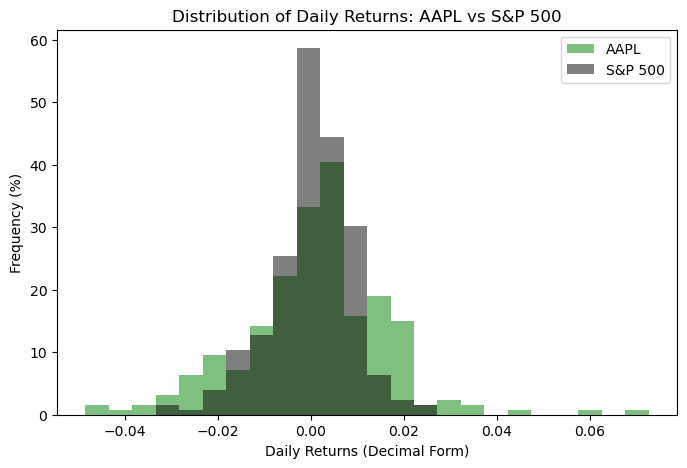

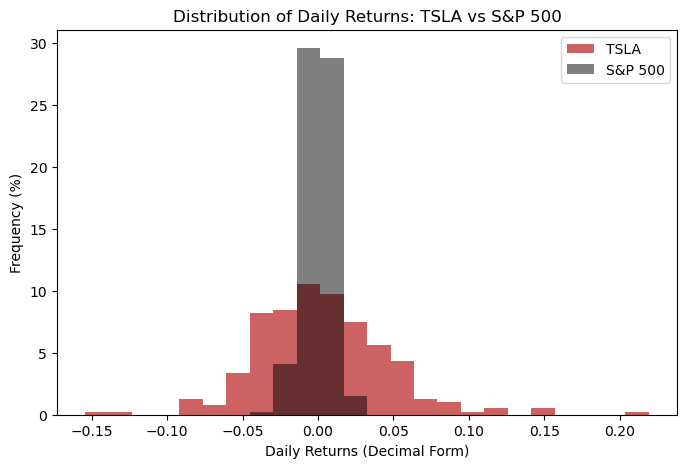

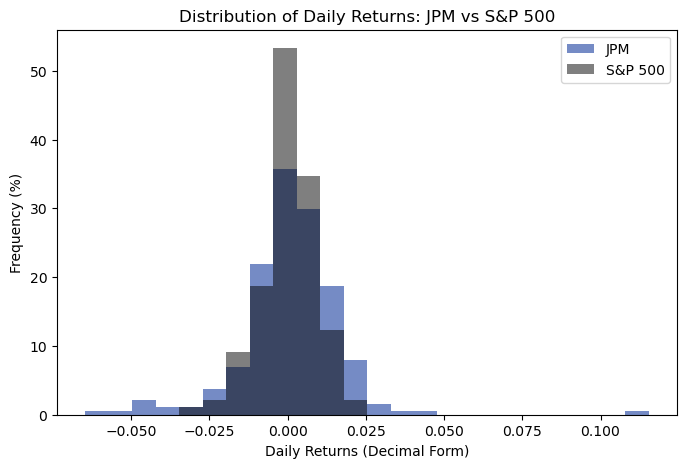

In [3]:
# Plotting AAPL returns vs S&P 500 to visually analyze AAPL beta
# Combine returns for shared binning
plt.figure(figsize=(8, 5))
combined_AAPL = np.concatenate([returns["AAPL"].dropna(), returns["^GSPC"].dropna()])

# Define common bins for consistency
bins_AAPL = np.linspace(combined_AAPL.min(), combined_AAPL.max(), 25)

# Plot
plt.hist(returns["AAPL"], bins=bins_AAPL, alpha=0.5, label="AAPL", density=True, color = "Green")
plt.hist(returns["^GSPC"], bins=bins_AAPL, alpha=0.5, label="S&P 500", density=True, color = "Black")
plt.legend()
plt.xlabel("Daily Returns (Decimal Form)")
plt.ylabel("Frequency (%)")
plt.title("Distribution of Daily Returns: AAPL vs S&P 500")
plt.show()

# Repeating for TSLA and JPM
plt.figure(figsize=(8, 5))
combined_TSLA = np.concatenate([returns["TSLA"].dropna(), returns["^GSPC"].dropna()])
bins_TSLA = np.linspace(combined_TSLA.min(), combined_TSLA.max(), 25)
plt.hist(returns["TSLA"], bins=bins_TSLA, alpha=0.7, label="TSLA", density=True, color = "#b82020")
plt.hist(returns["^GSPC"], bins=bins_TSLA, alpha=0.5, label="S&P 500", density=True, color = "Black")
plt.legend()
plt.xlabel("Daily Returns (Decimal Form)")
plt.ylabel("Frequency (%)")
plt.title("Distribution of Daily Returns: TSLA vs S&P 500")
plt.show()

plt.figure(figsize=(8, 5))
combined_JPM = np.concatenate([returns["JPM"].dropna(), returns["^GSPC"].dropna()])
bins_JPM = np.linspace(combined_JPM.min(), combined_JPM.max(), 25)
plt.hist(returns["JPM"], bins=bins_JPM, alpha=0.7, label="JPM", density=True, color = "#3a5aad")
plt.hist(returns["^GSPC"], bins=bins_JPM, alpha=0.5, label="S&P 500", density=True, color = "Black")
plt.legend()
plt.xlabel("Daily Returns (Decimal Form)")
plt.ylabel("Frequency (%)")
plt.title("Distribution of Daily Returns: JPM vs S&P 500")
plt.show()

Analyzing the histograms of the returns versus the S&P 500 can **provide insight into whether beta is greater than, roughly equal to, or less than 1.** Since The S&P 500, by definition, has a beta value of 1, a stock with a larger beta would typically have greater volatility, reflected as a wider spread in its return histogram. In a density plot histogram, this would appear as the stock's histogram being wider than that of the S&P 500's.

Examining the histograms for Apple and Tesla, this pattern is evident, suggesting that their **beta may be greater than 1.** On the other hand, the JPMorgan Chase histogram roughly follows the S&P 500 histogram, indicating the JPM **beta may be closer to 1**. This observation aligns with the expectations based on the companies' business models: JPMorgan, as a financial services institution, typically exhibits lower levels of risk and, consequently, has a beta closer to 1. In contrast, innovative technology companies like Tesla are more exposed to market fluctuations and have a higher beta.

# Beta Estimation

In this section, the **least squares regression line** for the graph of the stocks' returns versus the S&P 500 returns is determined. As aforementioned, according to the Capital Asset Pricing Model, the relationship between return and the expected return of the market is linear. Thus, **the slope of this least squares regression line will estimate the beta value of the stock.** Other information from the linear regression such as alpha and the coefficient of determination ($R^2$) can be used to further describe the risk profiles of the 3 stocks.

In [4]:
# AAPL linear regression
AAPL_linreg = sp.stats.linregress(returns["^GSPC"], returns["AAPL"], nan_policy = "omit")

# TSLA linear regression
TSLA_linreg = sp.stats.linregress(returns["^GSPC"], returns["TSLA"], nan_policy = "omit")

# JPM linear regression
JPM_linreg = sp.stats.linregress(returns["^GSPC"], returns["JPM"], nan_policy = "omit")

# Organizing regression results into a DataFrame for Clarity
summary = pd.DataFrame({
    "Stock": ["AAPL", "TSLA", "JPM"],
    "Beta": [AAPL_linreg[0], TSLA_linreg[0], JPM_linreg[0]],
    "Alpha": [AAPL_linreg[1], TSLA_linreg[1], JPM_linreg[1]],
    "R^2": [AAPL_linreg[2] ** 2, TSLA_linreg[2] ** 2, JPM_linreg[2] ** 2],
})

## Linear Regression Results:
| Stock   | β (Beta) | α (Alpha) | R² |
|---------|----------|-----------|----|
| AAPL    | 0.961    | 0.001     | 0.298 |
| TSLA    | 2.808    | 0.002     | 0.324 |
| JPM     | 0.921    | 0.001     | 0.254 |


### Apple (AAPL):

- **$\beta$ = 0.961** → AAPL generally moves with the market
- **$\alpha$ = 0.001** → When the market returns 0%, AAPL's expected daily return is 0.1%
- **$R^2$ = 0.298** → Approximately 29.8% of AAPL's return variability is explained by changes in the market

### Tesla (TSLA):

- **$\beta$ = 2.808** → TSLA is more volatile than the market and is expected to move more
- **$\alpha$ = 0.002** → When the market returns 0%, TSLA is expected to return 0.2%
- **$R^2$ = 0.324** → 32.4% of the variability in TSLA returns can be explained by changes in the market

### JPMorgan Chase (JPM):

- **$\beta$ = 0.921** → JPM tends to move slightly less than the market on average
- **$\alpha$ = 0.001** → When the market returns 0%, JPM is expected to return 0.1%
- **$R^2$ = 0.254** → 25.4% of the variability in JPM returns can be explained by market movements

# Model Validation

In this section, the use of linear regression is validated by testing the returns data for the assumptions of linear regression: **linearity, independence, homoscedasticity, and normality.**

## Linearity

To evaluate the linearity of the returns data, the **residual plot of residual values versus fitted values** is examined. If the residual plot is reasonably **unpatterned**, the linearity assumption is satisfied. Linearity is important for linear regression because if the residual plot is patterned and the linearity assumption is not met, a different degree model could be more predictive.

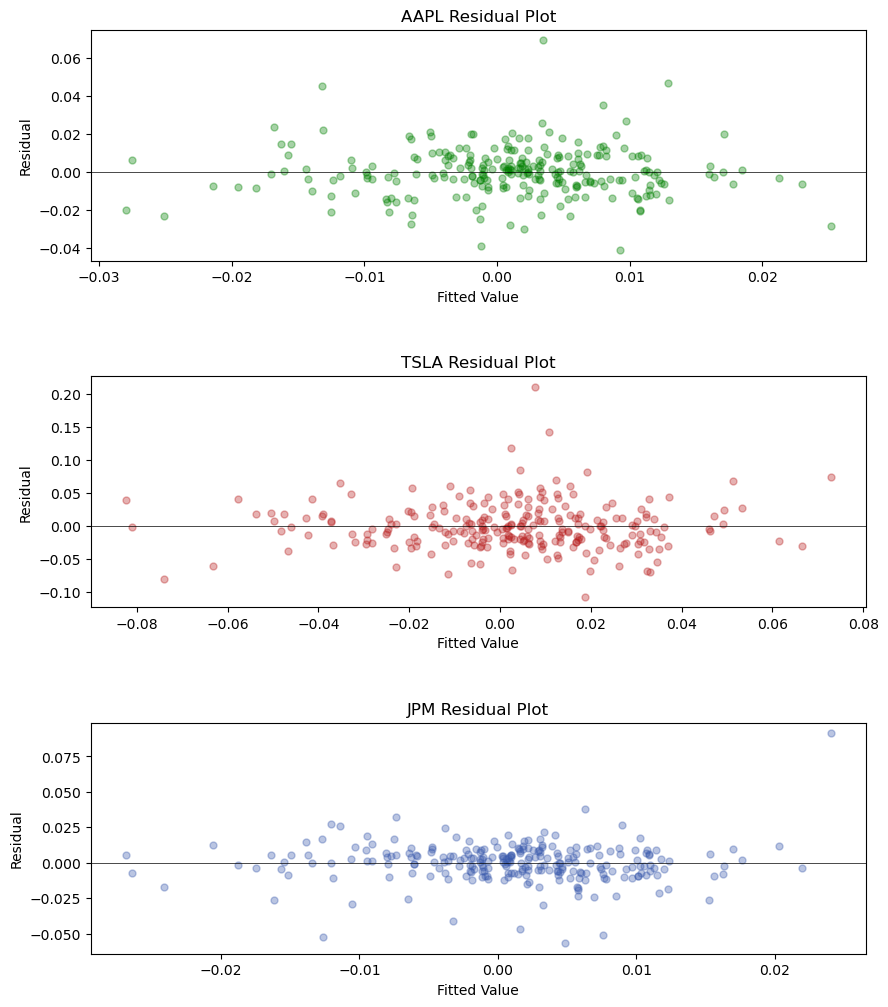

In [5]:
# Defining function to create DataFrame with residuals and fitted value
def residual(stock, beta, alpha):
    # Calculating fitted (predicted values) based on the regression
    fitted = returns["^GSPC"].multiply(beta).add(alpha)
    # Creating DataFrame with fitted and residual values
    residuals = pd.DataFrame({
        "fitted": fitted,
        "residual": returns[stock].subtract(fitted)
    })
    return residuals

# Calculating residuals and fitted values for the stocks
AAPL_residuals = residual("AAPL", summary["Beta"][0], summary["Alpha"][0])
TSLA_residuals = residual("TSLA", summary["Beta"][1], summary["Alpha"][1])

JPM_residuals = residual("JPM", summary["Beta"][2], summary["Alpha"][2])

# Subplot Setup
resplots, ax = plt.subplots(3, 1, figsize = (10, 12))
plt.subplots_adjust(hspace=0.5)

# Creating AAPL residual plot
plt.subplot(3, 1, 1)
plt.scatter(AAPL_residuals["fitted"], AAPL_residuals["residual"], s = 25, alpha = 0.35, c = "green")
plt.title("AAPL Residual Plot")
plt.ylabel("Residual")
plt.xlabel("Fitted Value")
plt.axhline(y=0, color='black', linewidth=0.5)

# Creating TSLA residual plot
plt.subplot(3, 1, 2)
plt.scatter(TSLA_residuals["fitted"], TSLA_residuals["residual"], s = 25, alpha = 0.35, c = "#b82020")
plt.title("TSLA Residual Plot")
plt.ylabel("Residual")
plt.xlabel("Fitted Value")
plt.axhline(y=0, color='black', linewidth=0.5)

# Creating JPM residual plot
plt.subplot(3, 1, 3)
plt.scatter(JPM_residuals["fitted"], JPM_residuals["residual"], s = 25, alpha = 0.35, c = "#3a5aad")
plt.title("JPM Residual Plot")
plt.ylabel("Residual")
plt.xlabel("Fitted Value")
plt.axhline(y=0, color='black', linewidth=0.5);

All three residual plots are unpatterned, thus the linearity assumption of linear regression is valid for the three linear regressions performed on the stocks.

## Independence

In linear regression, it is important that each data point is **sufficiently independent from the others.** If the data is influenced by the other data points, it could make the linear regression less effective in predicting other values. One way to determine independence is by testing **autocorrelation, the similarity of variable between two successive time intervals.** The Durbin-Watson statistic provides a method of determining autocorrelation and in turn, independence. It is expressed by:

$\huge d = \frac{\sum_{t=2}^{T} (e_t - e_{t-1})^2}{\sum_{t=1}^{T} e_t^2}$  
Where:
- $d =$ Durbin-Watson statistic (always in between 0 and 4)
- $t =$ Time period of observation
- $T =$ Total number of time observations (data points)
- $e_t =$ Residual at time of observation
-  $e_{t-1} =$ Residual of previous observation

Depending on the value of the Durbin-Watson statistic, autocorrelation can be determined:
- **$0 < d < 1.5$:** → Positive autocorrelation 
- **$1.5 \le d \le 2.5$** → Negligeable autocorrelation (data points are independent of one another)
- **$2.5 < d < 4$** → Negative autocorrelation

In [6]:
# Creating a function to calculate Durbin-Watson statistic
def dw(stock_residual):
    residuals = stock_residual["residual"]
    num = ((residuals - residuals.shift(1)) ** 2).sum()
    den = (residuals ** 2).sum()
    return num / den

# Formatting DataFrame with Durbin-Watson statistics for the 3 stocks
dwstat = pd.DataFrame({
    "AAPL": [dw(AAPL_residuals)],
    "TSLA": [dw(TSLA_residuals)],
    "JPM": [dw(JPM_residuals)]
})

### Durbin-Watson Statistics:
| Stock   | AAPL | TSLA | JPM |
|---------|----------|---------|----------|
| d  | 1.907    | 1.831 | 2.251 | 

Since the **Durbin-Watson statistic for all three stocks falls within $1.5 \le d \le 2.5$,** there is negligible autocorrelation between the stocks' returns and the data points are independent, validating the independence assumption for linear regression.

## Homoscedasticity

Another important assumption of linear regression is that the data is homoscedastic, meaning **the variation in the residuals is constant across the level of independent variable.** In the context of this estimation, it would mean that the variation in stock return is the same, regardless of market return. Through the Breusch-Pagan test, the homoscedasticity of the data can be evaluated.

### Breusch-Pagan Test

The Breusch-Pagan test evaluates the level of homoscedasticity by **evaluating the significance of the variance** of the regression of the squared residuals versus the fitted values. The test provides a p-value where:

- **p-value $\ge \alpha$** → Stock is homoscedastic (fail to reject the $\mu_0$ that stock is homoscedastic)
- **p-value $< \alpha$** → Stock is heteroscedastic (reject $\mu_0$)

In this project, the commonly-used **$\alpha$ = 0.05** is applied.

In [7]:
# Creating function to perform Breusch-Pagan test
def bp(stock):
    # Square residuals
    ressq = stock["residual"] ** (2)
    # Run auxiliary regression and determine R-squared value
    rsq = sp.stats.linregress(stock["fitted"], ressq)[2] ** (2)
    # Calculate Lagrange multiplier test statistic
    lm = len(ressq) * (rsq)
    # Calculate chi square p-value
    pv = 1 - chi2.cdf(lm, df=1)
    return pv

# Calculating Breusch-Pagan p-values for stocks
bppvals = pd.DataFrame({
    "AAPL": [bp(AAPL_residuals)],
    "TSLA": [bp(TSLA_residuals)],
    "JPM": [bp(JPM_residuals)]
})

### Breusch-Pagan p-values:

| Stock   | AAPL | TSLA | JPM |
|---------|----------|---------|----------|
| p-value  | 0.994    | 0.553 | 0.051 | 

In the case of AAPL and TSLA, the **p-values are clearly larger than $\alpha$ (0.05)**, therefore they are homoscedastic and satisfy the homoscedasicity assumption of linear regression. On the other hand, JPM is just barely above $\alpha$, so to mantain the rigor of the model, further investigation is warranted. Returning to the JPM residual plot in the linearity section, there are **no obvious clumps of residual values and no trends.** Since there are **no heteroscedastic patterns** in JPM's residual plot, it can safely be determined to also be homoscedastic.

## Normality

The last assumption of linear regressions is that the residuals are normally distributed. One way to test this principle are quantile-quantile (QQ) plots. By plotting the **standardized residuals against the expected residuals** in a normal distribution, the normality of the residuals can be visualized. The closer a QQ plot's points are to the reference line with slope 1, the more normal the residuals are. For the purposes of this project, a QQ plot with a linear pattern close to the reference line will suffice to demonstrate normality.

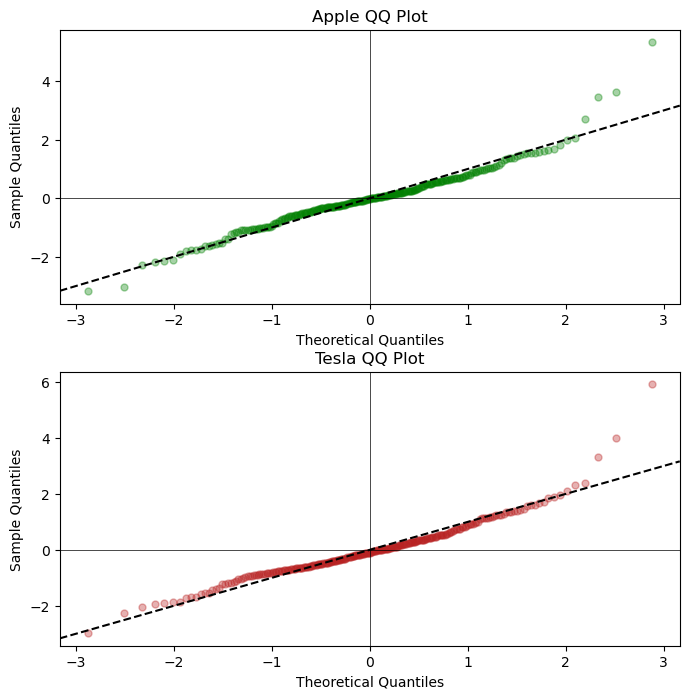

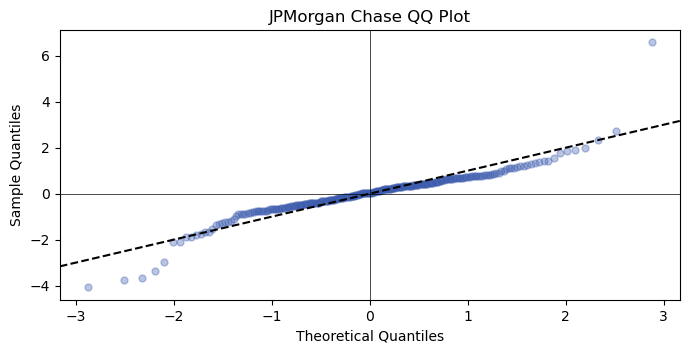

In [8]:
# Creating a function to find the points on a QQ graph for a given data set
def qq(stock):
    # Sorting the residuals (smallest to biggest)
    sorted_residuals = np.sort(stock["residual"])
    # Standardizing residuals (mean = 0, std = 1)
    standard_res = (sorted_residuals - np.mean(sorted_residuals))/np.std(sorted_residuals)
    # Computing quantile of value if data were perfectly normal
    n = len(sorted_residuals)
    probs = (np.arange(1, n + 1) - 0.5)/n
    quantiles = norm.ppf(probs)
    # Returning points on the QQ graph
    qqval = pd.DataFrame({"res": standard_res, "qnt": quantiles})
    return qqval

# Setting up subplots
qqplots, ax = plt.subplots(2, 1, figsize = (8, 8))
plt.subplots_adjust(hspace=0.25)

# Creating AAPL QQ plot
AAPL_qq = qq(AAPL_residuals)
plt.subplot(2, 1, 1)
plt.scatter(AAPL_qq["qnt"], AAPL_qq["res"], s = 25, alpha = 0.35, c = "green")
plt.axhline(y=0, color='black', linewidth=0.5)
plt.axvline(x=0, color='black', linewidth=0.5)
plt.axline((0, 0), slope=1, color='black', linestyle='--')
plt.ylabel("Sample Quantiles")
plt.xlabel("Theoretical Quantiles")
plt.title("Apple QQ Plot")

# Creating TSLA QQ plot
TSLA_qq = qq(TSLA_residuals)
plt.subplot(2, 1, 2)
plt.scatter(TSLA_qq["qnt"], TSLA_qq["res"], s = 25, alpha = 0.35, c = "#b82020")
plt.axhline(y=0, color='black', linewidth=0.5)
plt.axvline(x=0, color='black', linewidth=0.5)
plt.axline((0, 0), slope=1, color='black', linestyle='--')
plt.ylabel("Sample Quantiles")
plt.xlabel("Theoretical Quantiles")
plt.title("Tesla QQ Plot")

# Creating JPM QQ plot
qqplots, ax = plt.subplots(figsize = (8, 3.5))
JPM_qq = qq(JPM_residuals)
plt.subplot(1, 1, 1)
plt.scatter(JPM_qq["qnt"], JPM_qq["res"], s = 25, alpha = 0.35, c = "#3a5aad")
plt.axhline(y=0, color='black', linewidth=0.5)
plt.axvline(x=0, color='black', linewidth=0.5)
plt.axline((0, 0), slope=1, color='black', linestyle='--')
plt.ylabel("Sample Quantiles")
plt.xlabel("Theoretical Quantiles")
plt.title("JPMorgan Chase QQ Plot");

As seen in all three QQ plots, the values tend to stick **close to a line with slope 1, indicating that the residuals for all three stocks are normally distributed** and satisfying the final assumption of linear regression.

# Visualizations

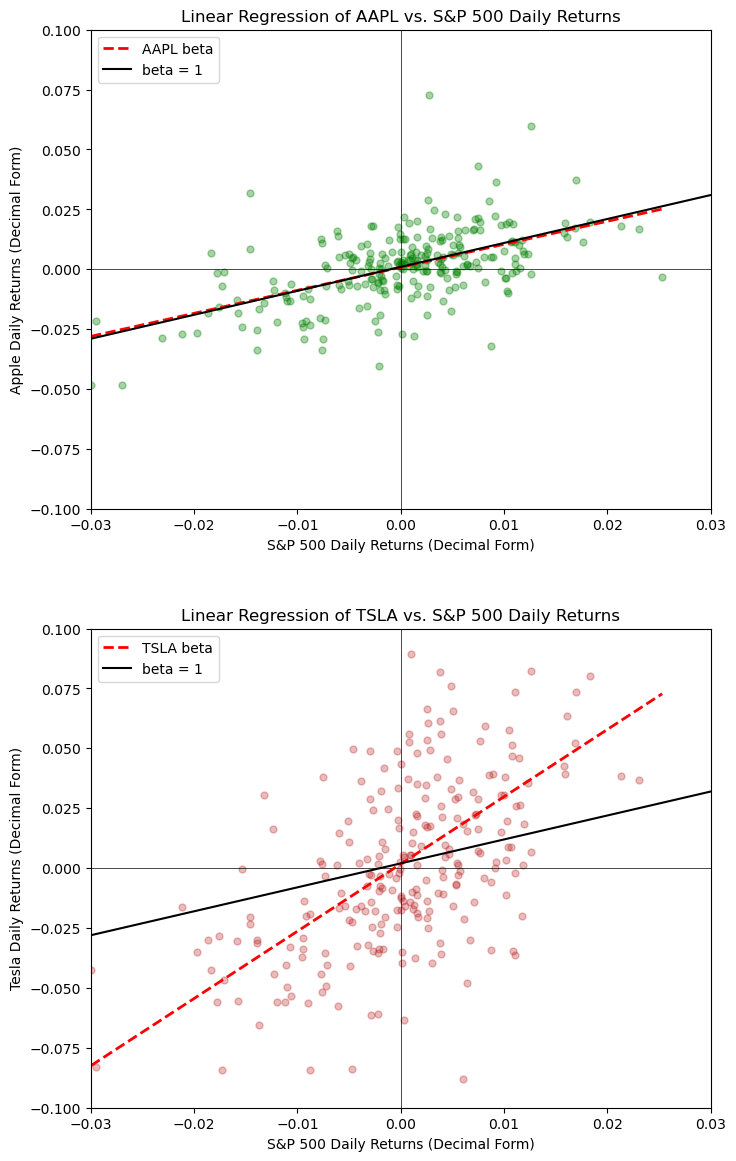

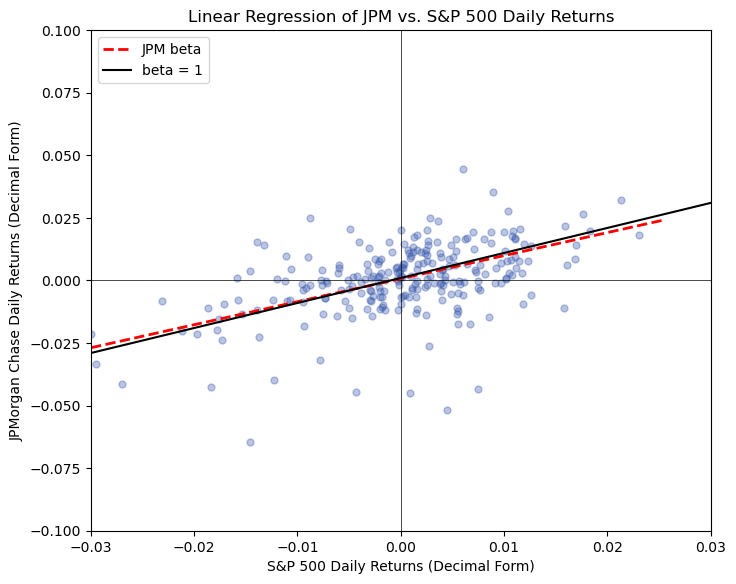

In [9]:
# Setting up subplots
vis, axs = plt.subplots(2, 1, figsize=(8, 14))
for ax in axs:
    ax.set_xlim(-0.03, 0.03)
    ax.set_ylim(-0.1, 0.1)
plt.subplots_adjust(hspace=0.25)

# Creating AAPL beta visualization graph
plt.subplot(2, 1, 1)
plt.scatter(returns["^GSPC"], returns["AAPL"], s = 25, c = "green", alpha = 0.35)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
sb.regplot(x = returns["^GSPC"], y = returns["AAPL"], scatter = False, ci = 0, label = "AAPL beta", line_kws = {"linestyle": "--", "linewidth": 2, "color":  "red"})
plt.ylabel("Apple Daily Returns (Decimal Form)")
plt.xlabel("S&P 500 Daily Returns (Decimal Form)");
plt.title("Linear Regression of AAPL vs. S&P 500 Daily Returns")
plt.plot([-0.03, 0.03], [-0.029, 0.031], color='black', label = "beta = 1")
plt.legend(loc = "upper left")

# Repeating for TSLA
plt.subplot(2, 1, 2)
plt.scatter(returns["^GSPC"], returns["TSLA"], s = 25, c = "#b82020", alpha = 0.3)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
sb.regplot(x = returns["^GSPC"], y = returns["TSLA"], scatter = False, ci = 0, label = "TSLA beta", line_kws = {"linestyle": "--", "linewidth": 2, "color": "red"})
plt.ylabel("Tesla Daily Returns (Decimal Form)")
plt.xlabel("S&P 500 Daily Returns (Decimal Form)");
plt.title("Linear Regression of TSLA vs. S&P 500 Daily Returns")
plt.plot([-0.03, 0.03], [-0.028, 0.032], color='black', label = "beta = 1")
plt.legend(loc = "upper left")

# Repeating for JPM
vis, ax = plt.subplots(figsize=(8, 6.5))
plt.subplot(1, 1, 1)
ax.set_xlim(-0.03, 0.03)
ax.set_ylim(-0.1, 0.1)
plt.scatter(returns["^GSPC"], returns["JPM"], s = 25, color = "#3a5aad", alpha = 0.35)
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)
sb.regplot(x = returns["^GSPC"], y = returns["JPM"], scatter = False, ci = 0, label = "JPM beta", line_kws = {"linestyle": "--", "linewidth": 2, "color":  "red"})
plt.ylabel("JPMorgan Chase Daily Returns (Decimal Form)")
plt.xlabel("S&P 500 Daily Returns (Decimal Form)");
plt.title("Linear Regression of JPM vs. S&P 500 Daily Returns")
plt.plot([-0.03, 0.03], [-0.029, 0.031], color='black', label = "beta = 1")
plt.legend(loc = "upper left");

Plotting the graphs of the daily stock returns versus the S&P 500, beta can be better visualized and interpreted. As previously stated, the slope of the regression (red-dashed) lines for the stocks are their respective betas. Comparing the regression lines to lines that share alpha, but have a beta of 1 (black lines), **a stock's beta can be visualized.** Both the JPM and AAPL graphs have regression lines that are slightly below the market lines. Since JPM and AAPL were determined to have betas that are slightly less than 1, this corroborates the previous findings. TSLA on the other hand has a beta line much steeper than the market's, indicating that it has a beta greater than 1. **Contextualizing the lines, the meaning of beta is uncovered: when the market moves one percent, JPM and AAPL are expected to move slightly less than that, while TSLA is expected to move over twice as much.** In other words, while JPM and AAPL are expected to be less volatile than the market, TSLA is expected to be almost three times as volatile.



# Conclusions

In this project, the CAPM Beta for Apple (AAPL), Tesla (TSLA), and JPMorgan Chase (JPM) were estimated, employing the S&P 500 (^GSPC) as a market benchmark. Estimating beta, each stock's sensitivity to market movements was assessed using historical return data from Q2 2024 to Q1 2025.

## Key Findings

### Apple (AAPL):
  - **$\beta$ = 0.961** → Apple generally moves alongside market
  -  **$R^2$ = 0.298** → Approximately 29.8% of AAPL's return variability is explained by market movements

### Tesla (TSLA):
  - **$\beta$ = 2.808** → TSLA is more volatile and is expected to move more
  - **$R^2$ = 0.324** → Around 32.4% of TSLA's return variability is explained by market changes  

### JPMorgan Chase (JPM):
  - **$\beta$ = 0.921** → JPM tends to move slightly less than the market
  - **$R^2$ = 0.254** → About 25.4% of JPM's return variability is driven by market performance

## Discussion

### AAPL Histogram-Beta Discrepancy
Interestingly, although AAPL's returns were observed to have more total variability than the S&P 500 in the AAPL vs. S&P 500 daily return histogram (with AAPL displaying a wider spread of returns), its beta was estimated to be less than 1. While this discrepancy may seem contradictory, it highlights an important distinction: beta measures a stock's sensitivity to market-wide movements, not its total volatility. AAPL's greater daily return variability could stem from **idiosyncratic factors, such as firm actions and sector-exclusive changes, which contribute to volatility but are independent of broader market fluctuations.**

### Low $R^2$ Values
In the linear regressions between each stock's daily returns and the market's returns, AAPL, TSLA, and JPM all exhibited low $R^2$ values of around 0.3. These $R^2$ values indicate that only around 30% of the variability in the daily returns of the stocks is explained by broader market movements. However, these low $R^2$ values are to be expected because **short-term stock performance tends to be heavily influenced by idiosyncratic factors such as firm-specific news and sector developments rather than solely by market-wide trends.**

### Firm-Specific vs. Market Risk
The results of the estimation highlight the difference between systemic risk, which reflects a stock's sensitivity to wider market movements, and idiosyncratic risk, which involves the conditions of a specific company or sector. Beta deals with systemic risk, providing insight into how a stock responds to differing market returns. On the other hand, $R^2$ can provide insight into idiosyncratic and other forms of risk not evaluated by beta. **The relatively low $R^2$ values found indicate that the total volatility of the stocks is more impacted by idiosyncratic and other forms of risk than systemic risk.** These results highlight the need to consider a variety of factors, beta and $R^2$ included, when determining the risk profile of an investment.

### Timeframe Concerns
In addressing the limitations of the estimation, it is important to acknowledge the relatively short timespan of the data. Since data was only taken data from a single year, **the model is particularly prone to noise from short-term price fluctuations and may not fully reflect the risk profiles of the stocks.** The beta and $R^2$ estimations are more susceptible to short-term volatility than estimations completed over a longer timeframe.

### Implications of Beta and $R^2$ for Investors
An understanding of both beta and $R^2$ is crucial for constructing a portfolio aligned with a certain threshold of risk. Stocks with high beta values, such as TSLA, may attract investors seeking greater exposure to market movements, since TSLA's high beta suggests larger potential returns but also higher exposure to market downturns. Conversely, a lower-beta stock like JPM might appeal to investors hoping for more stable returns and resistance to market fluctuations. However, as reflected in the low $R^2$ values, market movements only account for a portion of return variability. This highlights the need for investors to **consider firm-specific factors and other intrinsic properties of their investments.**

### Inclusion of Outlier Points
This analysis chose to include returns that are outside three standard deviations of the mean. While some of the outliers could prove to be leverage points, altering the linear regression and estimation of beta, they were included because the objective of the project is to calculate the beta of these stocks over a given time interval. **Excluding points from that time interval would therefore damage the estimation's temporal representativeness, as beta reflects all market conditions.**

### Limitations and Future Improvements
This analysis only employed the S&P 500 as a benchmark for market performance. In reality, returns are influenced by other factors not captured in the estimation, thus future research could apply more complex models, such as the **Fama-French Three-Factor Model,** to better capture the risk profiles and returns. Moreover, incorporating **sector-specific benchmarks** could improve the explanatory power of this analysis.